# Przewidywanie cen indeksów SPY za pomocą analizy technicznej i ML

## 1. Wstęp
W tym notebooku spróbuję użyć analizy techniczej i różnych technik uczenia maszynowego by przewidywać ceny futursa na indeks giełdowy SPY500. Będę głównie wzorował się na artykule: https://arxiv.org/pdf/1706.00948.pdf. Dalej będę się do niego odwoływał jako do Artykułu 1.

## 2. Dane
Dane biorę ze strony https://stooq.pl/q/d/?s=es.f skąd można za darmo pobrać dniowe dane dotyczące futursa na indeks SPY500. W danych mamy cenę otwarcia(Open), najwyższą(High), najniższą(Low) i zamknięcia(Close) oraz wolumen i liczbę otwartych pozycji(LOP). Dane są za lata 1998-2017.

## 3.Data preprocessing
Za pomocą danych stworze 9 wskaźników analizy techniczej użytych w Artykule 1: <br>
1)Oscylator stochastyczny <br>
2)Momentum <br>
3)ROC <br>
4)WillR% <br>
5)Disp5 <br>
6)Disp10 <br>
7)OSCP <br>
8)RSI <br>
9)CCI <br>
Po dokładny opis każdego wskaźnika odsyłam do artykułu 1, lub do https://en.wikipedia.org/wiki/Technical_analysis.<br>
Wskaźniki stworzę przy pomocy biblioteki TA-LIB(https://github.com/mrjbq7/ta-lib) <br>
Usunę również początkowe kolumny, by nasze przewidywania opierać tylko i wyłącznie na tych wskaźnikach.<br>
Jako zmienną celu wezmę zwrot w przeciągu 1, 3 i 5 dni.

In [1]:
def addTechnicalFeatures(df):
    df['Data'] = pd.to_datetime(df['Data'])
    df.columns = ['Data', 'Open','High', 'Low', 'Close', 'Wol', "Lop"]
    #Wskazniki analizy technicznej
    k, dfast = talib.STOCH(np.array(df['High']),np.array(df['Low']),
                           np.array(df['Close'])) # uses high, low, close by default
    df['k'] = k
    df['dfast'] = dfast
    df['dslow'] = talib.SMA(dfast, timeperiod=5)
    df['momentum'] = talib.MOM(np.array(df['Close']), timeperiod=4)
    df['roc'] = talib.ROC(np.array(df['Close']), timeperiod=5)
    df['willR'] = talib.WILLR(np.array(df['High']), np.array(df['Low']),
                        np.array(df['Close']), timeperiod = 5)
    #ad = talib.ADOSC(np.array(df['High']), np.array(df['Low']),
    #                          np.array(df['Close']), np.array(df['Wol']))
    df['disp5'] = df['Close'] / talib.SMA(np.array(df['Close']), 5) * 100
    df['disp10'] = df['Close'] / talib.SMA(np.array(df['Close']), 10) * 100
    df['oscp'] = ((talib.SMA(np.array(df['Close']), 5) - talib.SMA(np.array(df['Close']), 10)) / 
                                                        talib.SMA(np.array(df['Close']), 5)) 
    df['rsi'] = talib.RSI(np.array(df['Close']))
    df['CCI'] = talib.CCI(np.array(df['High']),np.array(df['Low']), np.array(df['Close']))
    #Tworzenie zmiennej celu
    df['target1'] = df['Close'].shift(-1) -df['Open']
    df['target5'] = df['Close'].shift(-5) -df['Open']
    df['target3'] = df['Close'].shift(-3) -df['Open']
    #zostawienie tylko zmiennej celu i wskaźników technicznych
    df.drop(['Data','Open', 'High', 'Low', 'Close', 'Wol', 'Lop'],axis=1, inplace=True)
    return df

In [2]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
df = pd.read_csv("/home/olaf/Finanse/es_f_d.csv")
price = df['Otwarcie']
df = addTechnicalFeatures(df)
df.head()

,k,dfast,dslow,momentum,roc,willR,disp5,disp10,oscp,rsi,CCI,target1,target5,target3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.00,51.75,25.00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.75,-28.50,36.75
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.50,22.75,12.25
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.50,44.50,-13.75
4,NaN,NaN,NaN,36.25,NaN,-1.694915,103.852512,NaN,NaN,NaN,NaN,-4.50,28.00,6.00


Jak widać w stworzenj bazie na początku mamy dużo NaNów, ponieważ często wskaźniki wykorzystują średnie z kilku ostatnich dni, co powoduje że dla pierwszych rekordów nie da się ich policzyć. Możemy je usunąc, gdyż nie wpłynie to znacząco na rozmiar bazy.

In [3]:
df.dropna(inplace=True, axis = 0)

In [4]:
df.head()

,k,dfast,dslow,momentum,roc,willR,disp5,disp10,oscp,rsi,CCI,target1,target5,target3
14,53.658048,59.837736,76.084719,-10.00,0.217181,-35.146444,100.251050,101.465917,0.011973,57.480315,76.784678,48.00,27.00,20.00
15,72.803347,60.625359,72.555658,50.00,2.933461,-0.000000,103.570743,104.675980,0.010559,63.744351,140.459161,14.25,-13.25,24.00
16,77.105032,67.855476,68.572686,22.25,2.380952,-33.538462,100.649661,101.393133,0.007333,57.987369,116.365914,-27.00,-82.50,-20.00
17,76.615385,75.507921,66.981654,19.50,1.915152,-36.615385,100.033313,100.793594,0.007543,57.439661,78.289474,10.25,-40.25,-27.00
18,65.064229,72.928215,67.350942,25.00,3.078042,-34.653465,100.591296,101.639423,0.010312,59.460249,108.673978,7.75,-50.75,-54.75


Pozostaje jeszcze znormalizować dane.

In [5]:
from sklearn.preprocessing import MinMaxScaler
X = df.drop(['target1','target3','target5'], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [59]:
pd.DataFrame(X).to_csv("daneAT.csv")
pd.DataFrame(df['target5']).to_csv('target.csv')

Podział na dane trenignowe i testowe

In [6]:
X_train = X[:-800]
X_test = X[-800:]
y1_train = df['target1'][:-800]
y1_test = df['target1'][-800:]
y3_train = df['target3'][:-800]
y3_test = df['target3'][-800:]
y5_train = df['target5'][:-800]
y5_test = df['target5'][-800:]

## 4.Modelowanie

Kluczowym pytaniem podczas modelowania jest odpowiedź na pytanie jak będziemy mierzyć jakość naszych modeli. Według mnie najlepszym pomysłem jest stworzenie krzywej średniego zwrotu inwestycji na osi y oraz odsetek inwestycji na osi x zależnie od wybranego poziomu odcięcia.

## 4.1 Wybór modeli
W naszej analizie wypróbuje model SVM, Random Forest i XGboost. Dodatkowo sprawdzę jak każdy model radzi sobie na różnych zmiennych celu(przewidywanie 1, 3 i 5 dni do przodu).

Jako że dane mają charakter czasowy to próbkę podzieliłem ze względu na datę. Ostatnie 800 obserwacji(jakieś 3 lata) będzie danymi testowymi.

Napiszmy funkcję liczącą metrykę by móc potem łatwo porownywać modele.

In [43]:
from sklearn.metrics import auc
def meanReturnCurve(y_true, y_pred):
    thresholds = np.unique(y_pred)
    meanReturn = []
    percent = []
    for thresh in thresholds:
        meanReturn.append(np.mean(y_true[y_pred >= thresh]))
        percent.append(sum(y_pred >= thresh)/len(y_pred))
    return auc(percent, meanReturn)

def plotMeanReturnCurve(y_true, y_pred, **kwargs):
    thresholds = np.unique(y_pred)
    meanReturn = []
    percent = []
    for thresh in thresholds:
        meanReturn.append(np.mean(y_true[y_pred >= thresh]))
        percent.append(sum(y_pred >= thresh)/len(y_pred))
    return plt.plot(percent, meanReturn, **kwargs)



## 4.2 Modelowanie

### 4.1 SVM, RF i XGBoost 

Poniżej porównamy wyniki SVM, Random Forest i XGBoost w przewidywaniu zwrotu w przeciągu 5 dni od zakupu futursa. 

In [60]:
from sklearn.svm import SVR
svr = SVR(kernel="linear")

In [61]:
svr.fit(X_train, y1_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [49]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth = 4)

In [50]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, colsample_bytree=0.7)

In [62]:
svr.fit(X_train, y5_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [63]:
meanReturnCurve(y5_test, svr.predict(X_test))

14.91826231041393

In [53]:
rf.fit(X_train, y5_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
meanReturnCurve(y5_test, rf.predict(X_test))

16.719459642687784

In [55]:
xgb.fit(X_train, y5_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
meanReturnCurve(y5_test, xgb.predict(X_test))

16.196305177768732

Według naszej miary najlepiej wypada XGBoost i Random Forest. Jednak jest to robione bez optymalizacji hiper parametrów, więc dużo się może jeszcze zmienić.

# 5. Analiza modelu

Sprawdźmy jak wygląda wykres średniego zwrotu od procentu inwestycji. Do tego skorzystamy plotMeanReturnCurve

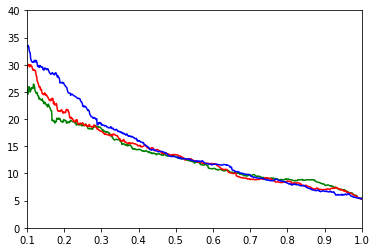

In [64]:
plotMeanReturnCurve(y5_test, svr.predict(X_test), color="green")
plotMeanReturnCurve(y5_test, xgb.predict(X_test), color="red")
plotMeanReturnCurve(y5_test, rf.predict(X_test), color="blue")
plt.ylim(0,40)
plt.xlim(0.1, 1)
plt.show()

Wykres pokazuje że gdy nasz model wybiera coraz mniej największych zwrot to średni zwrot rośnie. Pokazuje to, że im większa predykcja modelu tym większy potencialny zwrot z inwestycji. Przy wybieraniu 20% największych zwrotów z modelu średni zwrot z inwestycji wynosi około 20 punktów. <br>
Policzmy dla jakiej wartości to dokładnie wynosi i ile uzyskujemy poprawy od pasywnego inwestowania.

In [30]:
y_pred = svr.predict(X_test)

In [31]:
c = np.percentile(y_pred, 80)
print("80 percentyl przewidywanych zwrotów wynosi: ",c)

80 percentyl przewidywanych zwrotów wynosi:  7.26719358598


In [36]:
print("Inwestując pasywnie osiągamy zwrot %.2f, a z naszym modelem średnia wynosi %.2f" % 
     (y5_test.mean(), y5_test[y_pred > 7.26].mean()))

Inwestując pasywnie osiągamy zwrot 5.41, a z naszym modelem średnia wynosi 17.27


Jak widać jest to różnica która jest dość istotna co oznacza, że modelowanie danych inwestycyjnych przy pomocy analizy techinczej i modeli ma sens. <br>
Można również spróbować zwiększyć moc modelu przy pomocy szukania optymalnych parametrów naszych modeli czy testowania na różnych instrumentach finansowych.

Jeszcze sprawdźmy kiedy model podejmuje decyzje inwestycjne, tzn. zaznaczmy na wykresie ceny punkty, w których model powiedziałby "kup tutaj!"(y_pred > 4.14) w ciągu ostatych 300 dni roboczych i histogram rozkładu zysków z modelu.

In [37]:
col = y5_test[-800:-500][y_pred[-800:-500] > 7.26] > 0

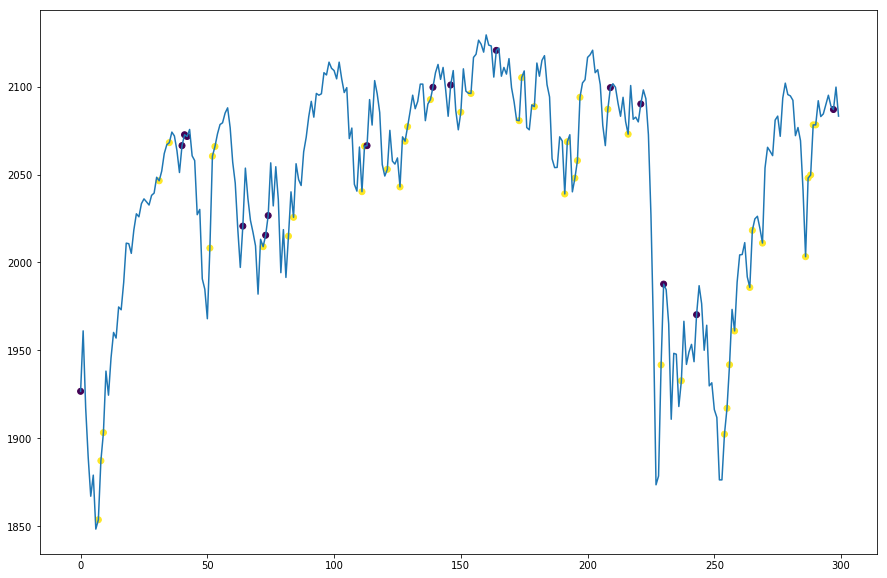

In [40]:
markers = np.where(y_pred[-800:-500] > 7.26)
plt.figure(figsize=(15,10))
plt.plot(range(300), price[-805:-505])
zplt.scatter(markers, price[-805:-505][y_pred[-800:-500] > 7.26], c=col)
plt.show()

Żółtymi kropkami zaznaczamy inwestycje z których zwrot był większy niż 0, a niebieskimi te które okazały się nie trafione. <br>
Z wykresu możemy dojrzeć, że model często wybiera punkty obok siebie, co oznacza że dni inwestycjnę będą się na siebie nakładać. Można to jednak to ograniczenie ominąć otwierając pozycje przy każdej pozytwnej informacji od modelu i posiadanie funduszy na otwarcie naraz kilku pozycji.

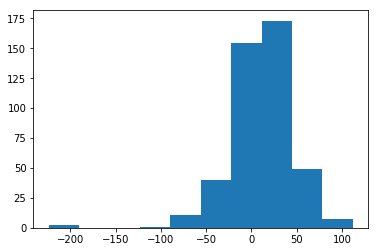

In [41]:
plt.hist(y5_test[y_pred > 4.14])
plt.show()

Histogram wyników przypomina(z grubsza) rozkład normlany z średnią 20. By to zweryfikować można przeprowadzić test Sharpiro-Wilka by potem modelować kolejne zwroty z modelu jako ruchy Browna. Ja jednak w dalszej analizię skupię się na poprawieniu modelu, by podkręcić średnie zwrotu z modelu.

# 6. Podsumowanie
Jak widać za pomocą analizy techinczej i metod ML można uzyskać lepsze wyniki niż pasywne inwestowane. Dalszym przedmiotem badań może być próba lepszego modelowania przy optymalizacji parametrów modelu lub używania dodatkowych metod jak np. AutoEnkodery, które są wspomniane w artykule 1 jako coś co poprawia wyniki SVM. Ciekawe jest również jak model radzi sobie na danych na których nie ma tak mocnego trendu wzrostowego jak na danych z indeksów giełdowych